In [1]:
from pathlib import Path

data_path = Path("FacialEmotionsData")

if data_path.is_dir():
    print("Path already exists...")
else:
    print("Creating Path...")
    data_path.mkdir(parents = True, exist_ok = True)

Path already exists...


In [2]:
import zipfile

with zipfile.ZipFile("archive.zip", "r") as f:
    print(f"Extracting contents from {f}...")
    f.extractall(data_path)

Extracting contents from <zipfile.ZipFile filename='archive.zip' mode='r'>...


In [3]:
import pandas as pd

df = pd.read_csv(data_path /"emotions.csv")
df.head()

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU


## Getting class names from the dataset

In [4]:
import os
import shutil

# Get the list of files in the "images/0" directory
files = os.listdir(os.path.join(data_path, "images", "0"))

# Extract emotions from filenames
emotions = [f.split('.')[0] for f in files]

# Sort the emotions and create class directories
class_names = sorted(emotions)
for emo in class_names:
    emo_dir = os.path.join("images", emo)
    os.makedirs(emo_dir, exist_ok=True)

In [5]:
import os
import shutil

source_dir = 'C:/Users/ozair/FacialEmotionsData/images'
destination_dir = 'images'

for dirname, _, filenames in os.walk(source_dir):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        emo = filename.split('.')[0]
        idi = os.path.basename(dirname)  # Extract folder name using os.path.basename
        newfile = f"{idi}_{filename}"
        
        # Create the emotion directory if it doesn't exist
        emo_dir = os.path.join(destination_dir, emo)
        os.makedirs(emo_dir, exist_ok=True)
        
        # Copy the file to the destination with the new name
        destination_path = os.path.join(emo_dir, newfile)
        shutil.copy(path, destination_path)

In [6]:
import torchvision.transforms as T
transform = T.Compose([
    T.Resize((224, 224)),      # Resize to 224x224 pixels
    T.ToTensor(),               # Convert to PyTorch tensor
])
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

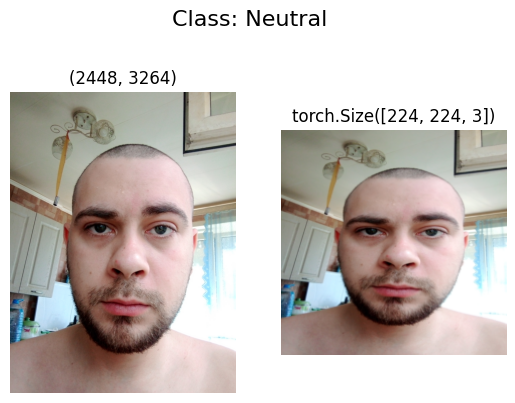

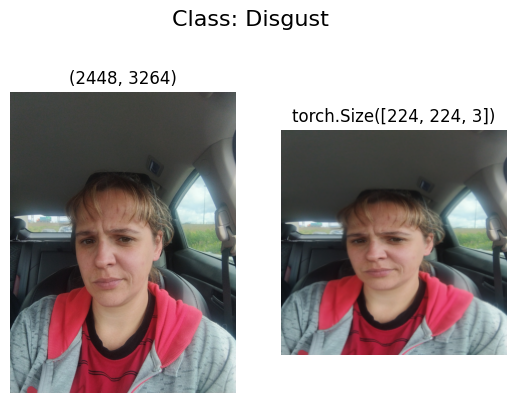

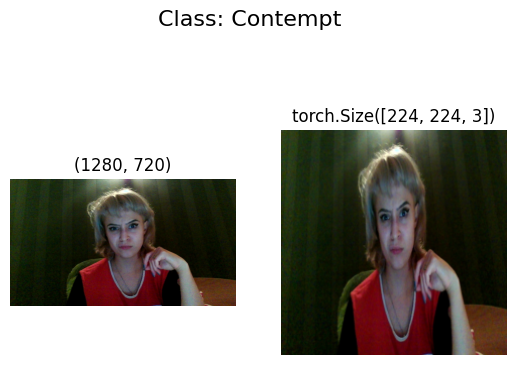

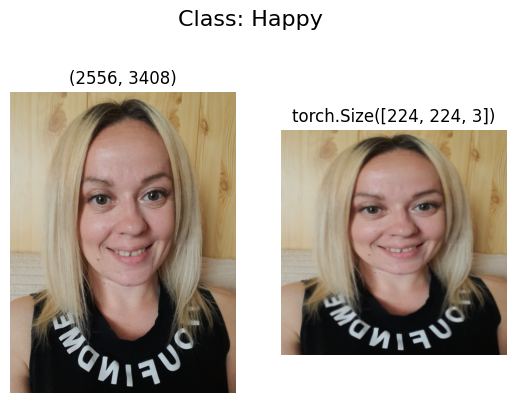

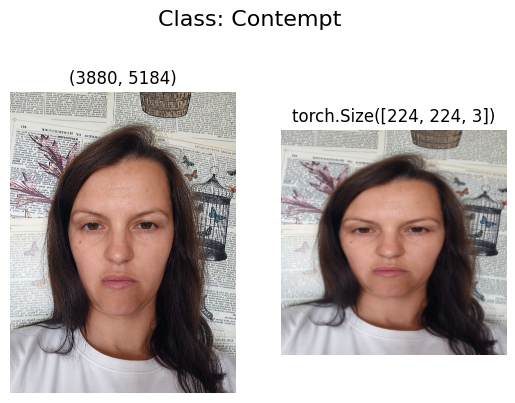

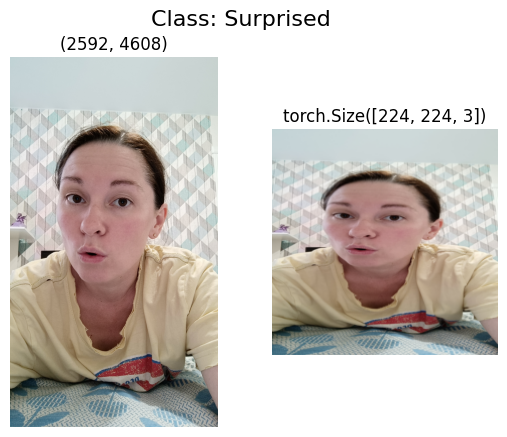

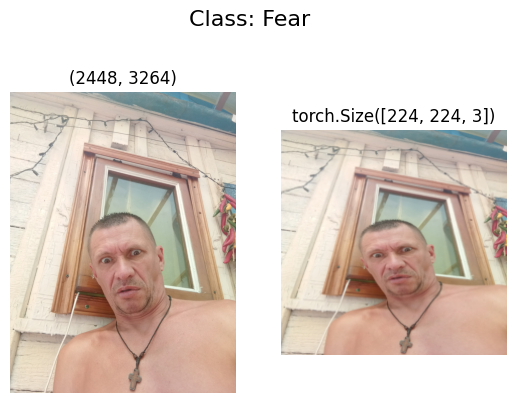

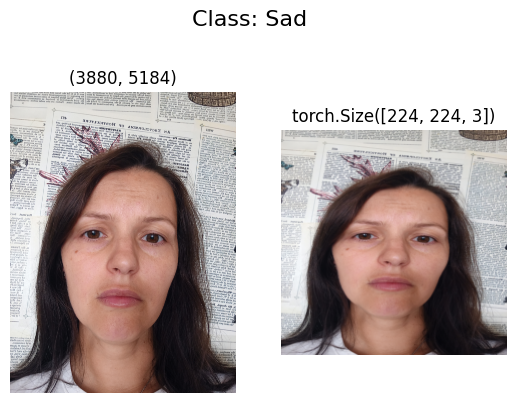

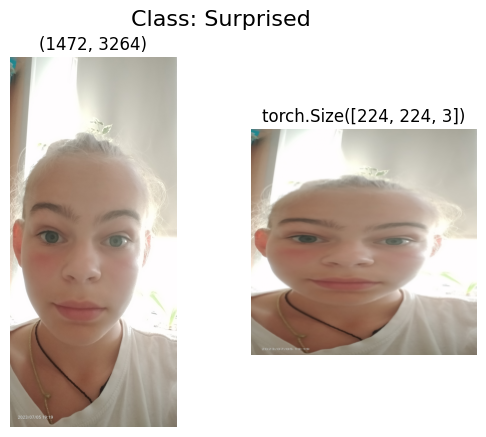

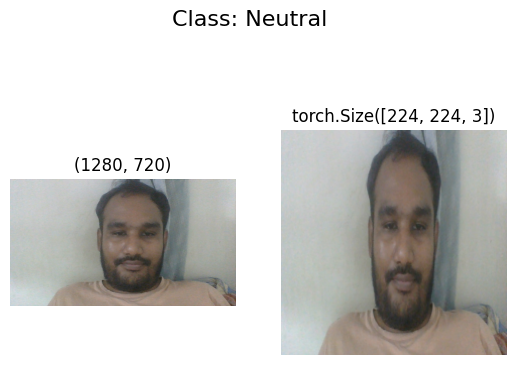

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random, glob

image_path = Path("images")


images = list(image_path.glob("*/*.jpg")) # List of all images in Windows Path format
random_images = random.choices(images, k = 10)

for images in random_images:
    with Image.open(images) as f:
        fig, ax = plt.subplots(nrows = 1, ncols = 2)
        ax[0].imshow(f)
        ax[0].set_title(f.size)
        ax[0].axis(False)
        
        transformed_images = transform(f).permute(1,2,0)
        ax[1].imshow(transformed_images)
        ax[1].set_title(transformed_images.shape)
        ax[1].axis(False)
        fig.suptitle(f"Class: {images.parent.stem}", fontsize=16)

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader


dataset = ImageFolder(root= image_path, transform = transform)

# Splitting the dataset into 80 / 20 ratio for training and testing
len_data = len(dataset)
train_len =int(0.6 * (len_data)) + 1
test_len = int(0.4 * (len_data))

print(f"Lenght of dataset : {len_data}, length of training data: {train_len}, length of testing data: {test_len}")
print(f"Sum of train_len and test_len equals: {train_len + test_len}")


# using pytorch's torch.utils.data.random_split function to split our facialemotions dataset into train and test samples.
#torch.utils.data.random_split(dataset, lengths, generator=<torch._C.Generator object>)
train_data, test_data  = random_split(dataset = dataset, lengths = [train_len, test_len])
# Turning our dataset into Dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f"The length of train dataloader is: {len(train_dataloader)}")
print(f"The length of test dataloader is: {len(test_dataloader)}")

Lenght of dataset : 152, length of training data: 92, length of testing data: 60
Sum of train_len and test_len equals: 152
The length of train dataloader is: 3
The length of test dataloader is: 2


In [9]:
class_names = dataset.classes
class_labels = dataset.class_to_idx
class_names, class_labels

(['Anger',
  'Contempt',
  'Disgust',
  'Fear',
  'Happy',
  'Neutral',
  'Sad',
  'Surprised'],
 {'Anger': 0,
  'Contempt': 1,
  'Disgust': 2,
  'Fear': 3,
  'Happy': 4,
  'Neutral': 5,
  'Sad': 6,
  'Surprised': 7})

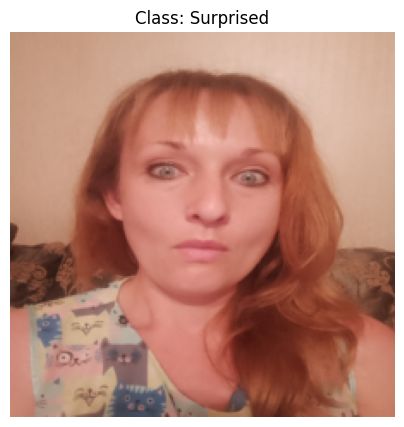

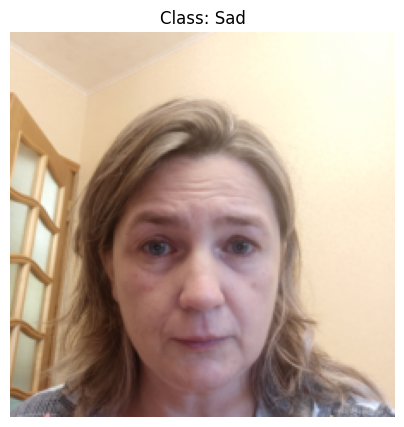

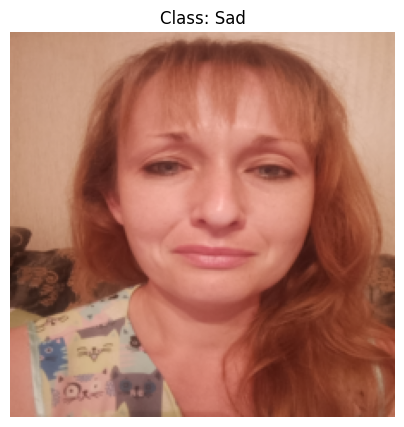

In [10]:
# Visualizing training and testing data
for i in range(0, 3):
    img, label = train_data[i][0], train_data[i][1]
    plt.figure(figsize = (5,5))
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Class: {class_names[label]}")
    plt.axis(False)

### Replicate the ResNet50 Paper:

In [11]:
# Import nn.Module from torch
import torch
from torch import nn

# Setup device agnostic code:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The current device torch is running on is: {device}")

The current device torch is running on is: cuda


In [12]:
# Building TinyVGG, yet again :>

class TinyVGG(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()   
        self.conv2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
            
        self.conv3 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
            
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 56 * 56, out_features = output_shape)
        )
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(self.relu2(self.conv2(x)))
        #print(x.shape)
        x = self.relu3(self.conv3(x))
        x = self.maxpool2(self.relu4(self.conv4(x)))
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

model = TinyVGG(input_shape=3, output_shape = len(class_names), hidden_units = 10)
model

TinyVGG(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=8, bias=True)
  )
)

In [13]:
dummy_x = torch.rand((1,3,224,224))
model(dummy_x)

tensor([[ 0.0602, -0.0072,  0.0219,  0.0228,  0.0032, -0.0287, -0.0376,  0.0237]],
       grad_fn=<AddmmBackward0>)

In [14]:
# Creating Trainig and Testing Loops
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim):
    
    # Setting the model to train mode
    model.train()
    
    # Setting up train_loss, train_acc variables for accumalating loss and acc values
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Sending data to device -> GPU
        X = X.to(device)
        y = y.to(device)
            
        # Performing the forward pass:
        y_logits = model(X)
        y_pred_labels = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
            
        # Calculate the loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
            
        # Calculate the acc
        acc =  (y_pred_labels == y).sum() / len(y_pred_labels)
        train_acc += acc.item()
            
        # Zero Gradient
        optimizer.zero_grad()
            
        # Backpropagation
        loss.backward()
            
        # Gradient Descent
        optimizer.step()
        
    # averaging out the correct train loss and accuracy values
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [15]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module):
    # Set the model to evaluation mode
    model.eval()
    
    # Setup test_loss and test_acc variables
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            # Set X and y on device mode:
            X = X.to(device)
            y = y.to(device)
            
            # Do the forward pass
            test_logits = model(X)
            test_pred_labels = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)
            
            # Calculate the loss
            loss = loss_fn(test_logits, y)
            test_loss += loss.item()
            
            # Calculate the accuracy
            acc = (test_pred_labels == y).sum() / len(test_pred_labels)
            test_acc += acc.item()
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [16]:
def train(model: nn.Module, 
          loss_fn: nn.Module, 
          optimizer: torch.optim, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader,
          epochs: int(5)):
    
    
    print(f"This training is for model:")
    # Create a results dictionary in order to store training and testing metrics
    results = {"train_loss": [], 
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}
    
    
    
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model = model, dataloader= train_dataloader, loss_fn= loss_fn, optimizer = optimizer)
        test_loss, test_acc = test_step(model = model, dataloader = test_dataloader, loss_fn = loss_fn)
        
        # Print Epoch, train loss, test_loss, train_acc, test_acc
        print(f"Epoch:{epoch} | train_loss:{train_loss:.4f} | train_acc:{train_acc:.4f} | test_loss:{test_loss:.4f} | test_acc:{test_acc:.4f}")
    
        # Append train and test metrics to the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [17]:
model_0 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=10)
# Send model to device
model_0.to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-3)

# Train the model:
model_results = train(model= model_0, 
                      loss_fn = loss_fn, 
                      optimizer = optimizer, 
                      train_dataloader= train_dataloader, 
                      test_dataloader= test_dataloader, 
                      epochs = 10)

This training is for model:
Epoch:0 | train_loss:2.5761 | train_acc:0.0893 | test_loss:2.2519 | test_acc:0.1362
Epoch:1 | train_loss:2.3569 | train_acc:0.1384 | test_loss:2.2100 | test_acc:0.1161
Epoch:2 | train_loss:2.2424 | train_acc:0.1280 | test_loss:2.2306 | test_acc:0.0513
Epoch:3 | train_loss:2.1824 | train_acc:0.1726 | test_loss:2.3963 | test_acc:0.0513
Epoch:4 | train_loss:2.1727 | train_acc:0.1488 | test_loss:2.2092 | test_acc:0.0982
Epoch:5 | train_loss:2.1119 | train_acc:0.1071 | test_loss:2.1154 | test_acc:0.1161
Epoch:6 | train_loss:2.0874 | train_acc:0.1324 | test_loss:2.1041 | test_acc:0.1161
Epoch:7 | train_loss:2.0748 | train_acc:0.1414 | test_loss:2.1280 | test_acc:0.0357
Epoch:8 | train_loss:2.0625 | train_acc:0.1830 | test_loss:2.1816 | test_acc:0.0357
Epoch:9 | train_loss:2.0444 | train_acc:0.1726 | test_loss:2.1741 | test_acc:0.0357


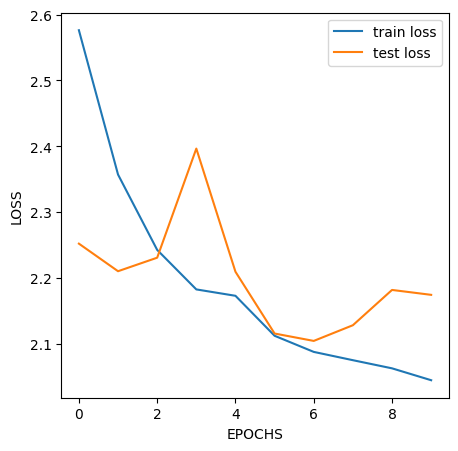

In [18]:
plt.figure(figsize=(5,5))
train_loss = plt.plot(model_results["train_loss"], label = "train loss")
test_loss = plt.plot(model_results["test_loss"], label = "test loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()

In [19]:
from torchvision.models import resnet18
resnet18 = resnet18()

class resnetfc(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features= len(class_names))
        )
    def forward(self, x):
        return self.classifier(x)

resnet18.fc = resnetfc()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
model_1 = resnet18
# Send model to device
model_1.to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 1e-3)

# Train the model:
model_results_1 = train(model= model_1, 
                      loss_fn = loss_fn, 
                      optimizer = optimizer, 
                      train_dataloader= train_dataloader, 
                      test_dataloader= test_dataloader, 
                      epochs = 15)

This training is for model:
Epoch:0 | train_loss:2.5286 | train_acc:0.1190 | test_loss:2.2601 | test_acc:0.0357
Epoch:1 | train_loss:2.4543 | train_acc:0.1265 | test_loss:2.4615 | test_acc:0.0692
Epoch:2 | train_loss:2.2259 | train_acc:0.1369 | test_loss:3.0682 | test_acc:0.0871
Epoch:3 | train_loss:1.9280 | train_acc:0.2619 | test_loss:2.6313 | test_acc:0.0357
Epoch:4 | train_loss:1.7006 | train_acc:0.4003 | test_loss:4.7002 | test_acc:0.1161
Epoch:5 | train_loss:1.4302 | train_acc:0.4628 | test_loss:7.4631 | test_acc:0.0513
Epoch:6 | train_loss:1.0494 | train_acc:0.7024 | test_loss:4.0438 | test_acc:0.0960
Epoch:7 | train_loss:0.7247 | train_acc:0.8095 | test_loss:6.8157 | test_acc:0.0848
Epoch:8 | train_loss:0.5264 | train_acc:0.8333 | test_loss:4.9727 | test_acc:0.0960
Epoch:9 | train_loss:0.3298 | train_acc:0.9464 | test_loss:6.2559 | test_acc:0.0491
Epoch:10 | train_loss:0.2538 | train_acc:0.9271 | test_loss:5.8158 | test_acc:0.0692
Epoch:11 | train_loss:0.2382 | train_acc:0.9658

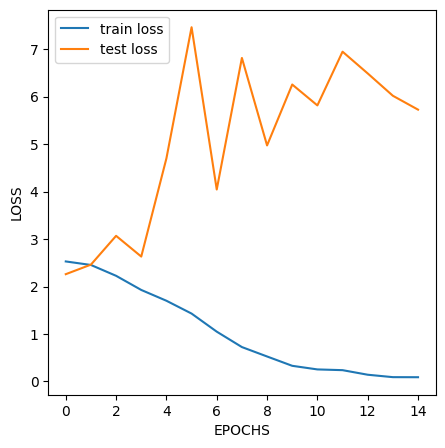

In [21]:
plt.figure(figsize=(5,5))
train_loss = plt.plot(model_results_1["train_loss"], label = "train loss")
test_loss = plt.plot(model_results_1["test_loss"], label = "test loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()

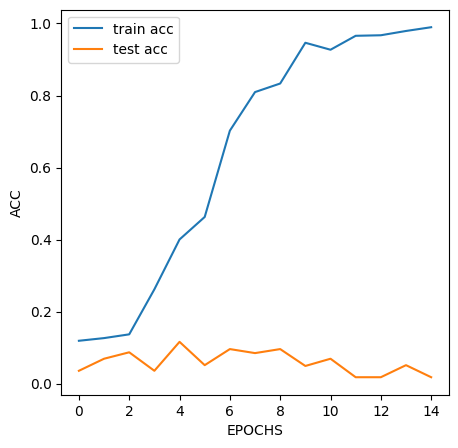

In [23]:
plt.figure(figsize=(5,5))
train_loss = plt.plot(model_results_1["train_acc"], label = "train acc")
test_loss = plt.plot(model_results_1["test_acc"], label = "test acc")
plt.xlabel("EPOCHS")
plt.ylabel("ACC")
plt.legend()

In [40]:
transform1 = T.Compose([
    T.Resize(size=(224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    #T.RandomRotation(2),
    #T.FiveCrop(224),
    T.TrivialAugmentWide(2),
    #T.ConvertImageDtype(torch.float32),
    T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform1

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    TrivialAugmentWide(num_magnitude_bins=2, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)

In [41]:
augmented_dataset = ImageFolder(root= image_path, transform = transform1)

# Splitting the dataset into 80 / 20 ratio for training and testing
len_data = len(augmented_dataset)
train_len =int(0.8 * (len_data)) + 1
test_len = int(0.2 * (len_data))

print(f"Lenght of augmented dataset : {len_data}, length of augmented training data: {train_len}, length of augmented testing data: {test_len}")
print(f"Sum of train_len and test_len equals: {train_len + test_len}")


# using pytorch's torch.utils.data.random_split function to split our facialemotions dataset into train and test samples.
#torch.utils.data.random_split(dataset, lengths, generator=<torch._C.Generator object>)
aug_train_data, aug_test_data  = random_split(dataset = augmented_dataset, lengths = [train_len, test_len])
# Turning our dataset into Dataloaders
BATCH_SIZE = 32
aug_train_dataloader = DataLoader(dataset=aug_train_data, batch_size = BATCH_SIZE, shuffle = True)
aug_test_dataloader = DataLoader(dataset = aug_test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f"The length of augmented train dataloader is: {len(aug_train_dataloader)}")
print(f"The length of augmented test dataloader is: {len(aug_test_dataloader)}")

Lenght of augmented dataset : 152, length of augmented training data: 122, length of augmented testing data: 30
Sum of train_len and test_len equals: 152
The length of augmented train dataloader is: 4
The length of augmented test dataloader is: 1


In [42]:
# Training ResNet18 with augmented dataset
model_1 = resnet18
# Send model to device
model_1.to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 1e-3)

# Train the model:
model_results_1 = train(model= model_1, 
                      loss_fn = loss_fn, 
                      optimizer = optimizer, 
                      train_dataloader= aug_train_dataloader, 
                      test_dataloader= aug_test_dataloader,
                      epochs =50)

This training is for model:
Epoch:0 | train_loss:1.0118 | train_acc:0.6088 | test_loss:1.4336 | test_acc:0.5333
Epoch:1 | train_loss:0.7712 | train_acc:0.7410 | test_loss:1.7956 | test_acc:0.6000
Epoch:2 | train_loss:0.6261 | train_acc:0.7746 | test_loss:1.7318 | test_acc:0.5667
Epoch:3 | train_loss:0.4785 | train_acc:0.8504 | test_loss:1.3207 | test_acc:0.5333
Epoch:4 | train_loss:0.4581 | train_acc:0.8407 | test_loss:1.1703 | test_acc:0.6333
Epoch:5 | train_loss:0.5606 | train_acc:0.7975 | test_loss:1.3568 | test_acc:0.5000
Epoch:6 | train_loss:0.5074 | train_acc:0.8215 | test_loss:1.3680 | test_acc:0.5000
Epoch:7 | train_loss:0.3973 | train_acc:0.8678 | test_loss:1.2764 | test_acc:0.5667
Epoch:8 | train_loss:0.4182 | train_acc:0.8600 | test_loss:1.5402 | test_acc:0.4000
Epoch:9 | train_loss:0.3606 | train_acc:0.8480 | test_loss:1.4502 | test_acc:0.5000
Epoch:10 | train_loss:0.4515 | train_acc:0.8287 | test_loss:1.6104 | test_acc:0.5333
Epoch:11 | train_loss:0.5282 | train_acc:0.8269

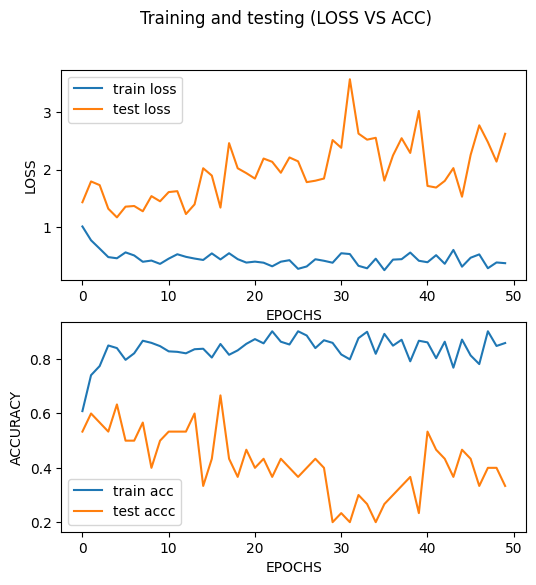

In [43]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training and testing (LOSS VS ACC)')
fig.set_size_inches(6,6)
# Plot for training and testing loss
ax1.plot(model_results_1["train_loss"], label = "train loss")
ax1.plot(model_results_1["test_loss"], label = "test loss")
ax1.set_xlabel("EPOCHS")
ax1.set_ylabel("LOSS")
ax1.legend()
# Plot for training and testing accuracy
ax2.plot(model_results_1["train_acc"], label = "train acc")
ax2.plot(model_results_1["test_acc"], label = "test accc")
ax2.set_xlabel("EPOCHS")
ax2.set_ylabel("ACCURACY")
ax2.legend()

In [44]:
test_image = transform1(Image.open(images))
test_image.shape

torch.Size([3, 224, 224])

In [45]:
model_1.eval()

predictions = []

for i in range(30):
    with torch.inference_mode():
        y_pred_labels = torch.argmax(torch.softmax(model_1(test_data[i][0].to(device).unsqueeze(dim = 0)), dim =1), dim = 1)
        predictions.append(y_pred_labels.cpu())
len(predictions)

30

In [46]:
class_labels

{'Anger': 0,
 'Contempt': 1,
 'Disgust': 2,
 'Fear': 3,
 'Happy': 4,
 'Neutral': 5,
 'Sad': 6,
 'Surprised': 7}

In [47]:
predicted_labels = []
for i in predictions:
    predicted_labels.append(i.item())
predicted_labels

[5,
 5,
 7,
 1,
 2,
 0,
 7,
 2,
 5,
 3,
 6,
 2,
 1,
 4,
 3,
 3,
 4,
 1,
 1,
 4,
 0,
 4,
 0,
 2,
 2,
 7,
 3,
 1,
 5,
 2]

In [48]:
test_samples_labels = []
for i in range(0,30):
    test_samples_labels.append(test_data[i][1])

test_samples_labels

[5,
 7,
 7,
 1,
 2,
 0,
 7,
 2,
 5,
 3,
 6,
 2,
 1,
 4,
 3,
 3,
 4,
 1,
 4,
 4,
 0,
 7,
 0,
 2,
 2,
 1,
 3,
 7,
 5,
 2]

In [49]:
correct_predictions = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == test_samples_labels[i]:
        correct_predictions.append(str("True"))
    else:
        correct_predictions.append(str("False"))
correct_predictions

['True',
 'False',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'False',
 'True',
 'True',
 'False',
 'True',
 'True',
 'True',
 'False',
 'True',
 'False',
 'True',
 'True']

### `Save the model and start working on the Streamlit webapp, Also this time you will be deploying it.`

In [50]:
# Saving the model
torch.save(model_1.state_dict(), "FacialEmo.pt")